This file takes segmented wav files and classifies the speaker using X-vector embeddings

In [3]:
import numpy as np
from speechbrain.pretrained import EncoderClassifier
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC

/Users/audri/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/zv/7g7rc4t52kx4pgdxw2c9g6740000gn/T/ipykernel_29063/431887787.py:2: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


Target date can be modified. Right now xvecs.npy contains embeddings for all the files.

In [19]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

def extract_embeddings(root_dir, target_date="1995_06_21"):
    embeddings = []
    labels = []

    for label in ["cm", "non_cm"]:
        folder = Path(root_dir) / label
        for wav_file in tqdm(folder.glob("*.wav"), desc=f"Processing {label}"):
            if target_date not in wav_file.name:
                continue
            try:
                signal = classifier.load_audio(str(wav_file))
                emb = classifier.encode_batch(signal).squeeze().detach().cpu().numpy()
                embeddings.append(emb)
                labels.append(1 if label == "cm" else 0)
            except Exception as e:
                print(f"Error with {wav_file}: {e}")

    return np.array(embeddings), np.array(labels)

X, y = extract_embeddings("segmented_wavs/")

Processing cm: 2047it [00:22, 90.98it/s] 
Processing non_cm: 2667it [00:41, 64.08it/s] 


For all:
X shape: (4714, 192)
y shape: (4714,)

In [20]:
print(X.shape)
print(y.shape)

(542, 192)
(542,)


In [6]:
np.save("xvecs.npy", X)

In [7]:
np.save("truthlabels.npy", y)

This classifies given embeddings into a binary non-CM and CM speaker

In [ ]:
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SVM
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Summary stats
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["non_cm", "cm"]))


              precision    recall  f1-score   support

      non_cm       0.98      0.97      0.97       534
          cm       0.96      0.97      0.97       409

    accuracy                           0.97       943
   macro avg       0.97      0.97      0.97       943
weighted avg       0.97      0.97      0.97       943



This identifies the overall number of speakers. Using cosine + agglomerative clustering. PLDA + AHC sounds especially promising for clustering these kinds of embeddings, but that requires multispeaker labels we don't have.

In [47]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AgglomerativeClustering

distance_matrix = cosine_distances(X)

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.9,  # Tuning this
    metric='precomputed',
    linkage='average'
)

labels = clustering.fit_predict(distance_matrix)

This is the number of speakers in the given audio:

In [44]:
print(len(set(labels)))

6


This visualises the clusters, should help tuning

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
xvec_2d = pca.fit_transform(X)

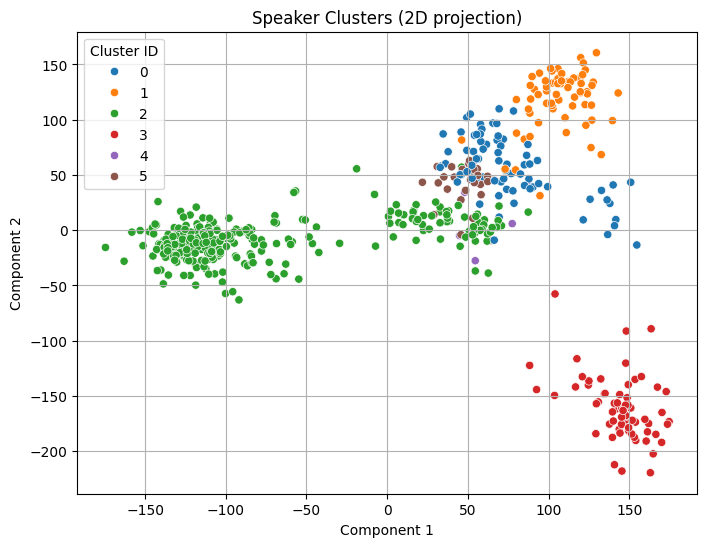

In [46]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=xvec_2d[:, 0], y=xvec_2d[:, 1], hue=labels, palette='tab10')
plt.title("Speaker Clusters (2D projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()
